# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandomProspino.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.0 #Include flat k-factor

#### Add c*tau column for charginos

In [4]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

In [5]:
# dataDF.columns.values.tolist()

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excluded'] == True]
allowed = dataDF[dataDF['excluded'] == False]
print('Total number of points = %i' %len(dataDF))
print('Total excluded = %i'%(len(excluded)))
print('Total allowed = %i'%(len(allowed)))

Total number of points = 47692
Total excluded = 3779
Total allowed = 43913


### Create analysis label for excluded points

In [7]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

In [8]:
print(excluded['label'].unique())

['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)' 'CMS-SUS-17-004 (TChiWZoff)'
 'CMS-SUS-17-004 (TChiWZ)' 'ATLAS-SUSY-2016-24 (TChiWZ)'
 'ATLAS-SUSY-2019-08 (TChiWH)' 'ATLAS-SUSY-2018-32 (TChiWW)'
 'CMS-SUS-13-006 (TChiWZoff)' 'ATLAS-SUSY-2013-12 (TChiWZ)'
 'ATLAS-SUSY-2017-03 (TChiWZ)']


### Get relevant official exclusion curves

In [9]:
excCurves = {}
excATLAS = np.genfromtxt('../EWino/data/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'] = np.array(list(zip(excATLAS['mC1_GeV'],1.967e-16/excATLAS['width_GeV'])))


excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
excCurves['ATLAS-SUSY-2016-24 (TChiWZ)'] = np.genfromtxt('../EWino/data/HEPData-ins1658902-v1-Table_20.csv',
                       delimiter=',', skip_header=9)
excCurves['ATLAS-SUSY-2019-08 (TChiWH)'] = np.genfromtxt('../EWino/data/HEPData-ins1755298-v1-Observed_limit_1lbb.csv',
                       delimiter=',', skip_header=11)
excCurves['ATLAS-SUSY-2018-32 (TChiWW)'] = np.genfromtxt('../EWino/data/HEPData-ins1750597-v1-Exclusion_contour_(obs)_1.csv',
                       delimiter=',', skip_header=10)
excCurves['CMS-SUS-13-006 (TChiWZoff)'] = np.genfromtxt('../EWino/data/CMS_SUS_13_006_TChiWZ_obs.csv', 
                                                      delimiter=',')

### Select data from allowed points

In [10]:
dataRed = allowed[(allowed['mass.1000024'] < 750) & (allowed['mass.1000024'] > 650) 
                  & (allowed['mass.1000022'] < 100)]
print(len(dataRed))

75


### Plot BRs

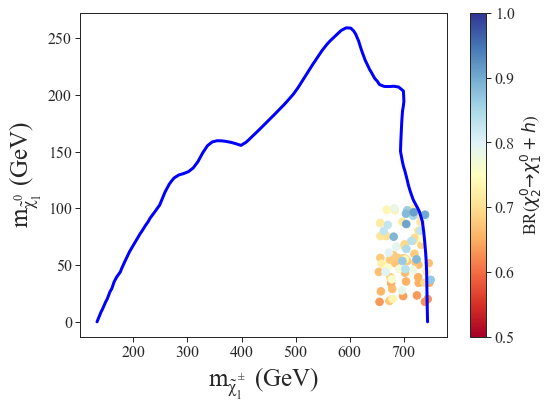

In [11]:
plt.figure(figsize=(8,6))

x = dataRed['mass.1000024']
y = dataRed['mass.1000022']
z = dataRed['BRs.N2.higgs,N1']*dataRed['BRs.C1+.W+,N1']
x = x.values[(z.values).argsort()]
y = y.values[(z.values).argsort()]
z = z.values[(z.values).argsort()]
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(x,y,c=z,cmap=cm,s=60,vmin=0.5,vmax=1)


curve = excCurves['ATLAS-SUSY-2019-08 (TChiWH)']
plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color='blue')
plt.colorbar(label=r'BR($\chi_2^0 \to \chi_1^0 + h$)')
# plt.ylim(0,700)
# plt.xlim(0,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

In [12]:
### NLL xsecs:
NLLxsec = np.array([[650,13.7303],[675.0,11.3975],[700.,9.51032],[725,7.9595],[750,6.69356]])
xsecNLLf = interp1d(NLLxsec[:,0],NLLxsec[:,1])

In [13]:
#Get points with large BR:
dataRed2 = dataRed[dataRed['BRs.N2.higgs,N1'] > 0.7]


axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)'}

for i,pt in dataRed2.iterrows():
    M1 = pt['extpar.1']
    M2 = pt['extpar.2']
    mu = pt['extpar.23']
    
    if mu < M2: continue #Remove higgsino points
        
        
    xsec = (pt['xsec13TeV(fb).1000023_1000024']+pt['xsec13TeV(fb).-1000024_1000023'])
    BR = pt['BRs.N2.higgs,N1']*pt['BRs.C1+.W+,N1']
    massC1 = pt['mass.1000023']
    massN2 = pt['mass.1000023']
    xsecNLL = xsecNLLf(massC1)
    kNLL = xsecNLL/xsec
    print(pt['filename'])
    print('masses = %1.2f (C1), %1.2f (N2)' %(massC1,massN2))
    print('xsec= %1.3f, BR = %1.2f' %(xsec,BR))
    print('k(NLL/NLO) = %1.2f' %(kNLL))
    print('r= %1.2f, r(NLL) = %1.2f, r(NLL+BR) = %1.2f' %(pt['ExptRes.result0.r'],pt['ExptRes.result0.r']*kNLL,
                                                     pt['ExptRes.result0.r']*kNLL/BR))
    print('\n')

ew_ko3il77e.slha
masses = 663.06 (C1), 663.06 (N2)
xsec= 11.870, BR = 0.83
k(NLL/NLO) = 1.05
r= 0.97, r(NLL) = 1.03, r(NLL+BR) = 1.24


ew_vuollfqm.slha
masses = 697.32 (C1), 697.32 (N2)
xsec= 8.890, BR = 0.87
k(NLL/NLO) = 1.09
r= 0.97, r(NLL) = 1.06, r(NLL+BR) = 1.22


ew_k8jozrqi.slha
masses = 666.04 (C1), 666.04 (N2)
xsec= 11.440, BR = 0.80
k(NLL/NLO) = 1.07
r= 0.96, r(NLL) = 1.03, r(NLL+BR) = 1.29


ew_jqyr1y_j.slha
masses = 681.29 (C1), 681.29 (N2)
xsec= 10.120, BR = 0.89
k(NLL/NLO) = 1.08
r= 0.96, r(NLL) = 1.04, r(NLL+BR) = 1.17


ew_19yj9ysz.slha
masses = 704.84 (C1), 704.84 (N2)
xsec= 8.870, BR = 0.85
k(NLL/NLO) = 1.04
r= 0.95, r(NLL) = 0.99, r(NLL+BR) = 1.17


ew_b0dbo4so.slha
masses = 704.53 (C1), 704.53 (N2)
xsec= 8.870, BR = 0.91
k(NLL/NLO) = 1.04
r= 0.94, r(NLL) = 0.98, r(NLL+BR) = 1.08


ew_56j5w2ky.slha
masses = 702.88 (C1), 702.88 (N2)
xsec= 8.600, BR = 0.84
k(NLL/NLO) = 1.09
r= 0.94, r(NLL) = 1.02, r(NLL+BR) = 1.22


ew_qvtrv_4v.slha
masses = 723.67 (C1), 723.67 (N2)
x